
=== Gonogo Data Summary ===
Sample size: 995
Age range: 6.2 - 18.7 years
Mean age: 12.4 ± 3.8 years

=== Go Accuracy Test–Retest Reliability ===
Valid n: 995
Baseline mean ± SD: 0.959 ± 0.045
Follow-up mean ± SD: 0.960 ± 0.044
Raw reliability: r = 0.949, p = 0.0000
Detrended reliability: r = 0.948, p = 0.0000
Age effect on baseline: β = 0.0042
Age effect on follow-up: β = 0.0031

=== NoGo Accuracy Test–Retest Reliability ===
Valid n: 995
Baseline mean ± SD: 0.870 ± 0.091
Follow-up mean ± SD: 0.875 ± 0.089
Raw reliability: r = 0.980, p = 0.0000
Detrended reliability: r = 0.964, p = 0.0000
Age effect on baseline: β = 0.0166
Age effect on follow-up: β = 0.0155

=== Go Reaction Time (ms) Test–Retest Reliability ===
Valid n: 995
Baseline mean ± SD: 459.932 ± 77.516
Follow-up mean ± SD: 453.398 ± 80.915
Raw reliability: r = 0.927, p = 0.0000
Detrended reliability: r = 0.897, p = 0.0000
Age effect on baseline: β = -12.4908
Age effect on follow-up: β = -11.4630

=== d' Test–Retest Reliability

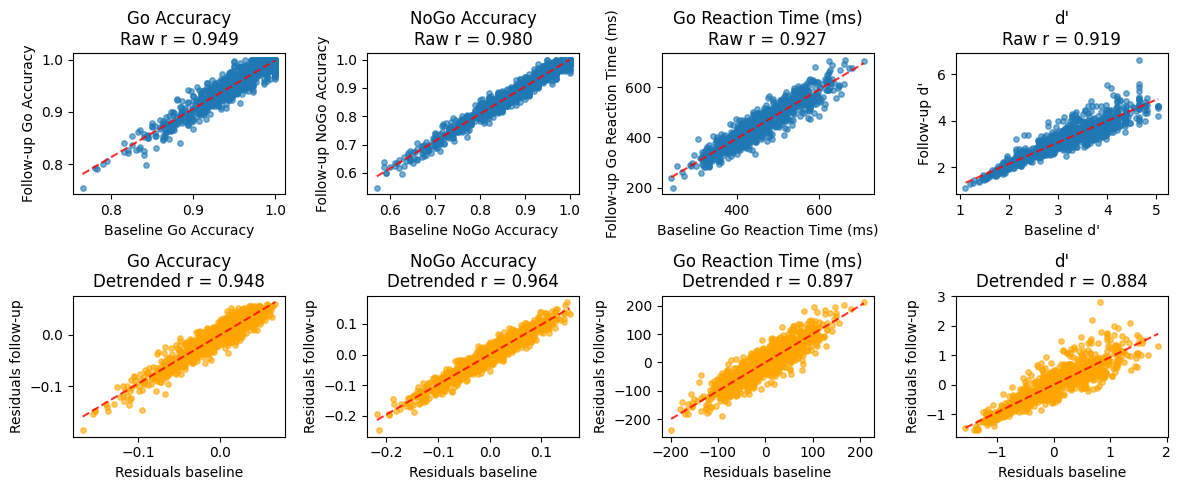


Gonogo Summary of Test–Retest Reliabilities
Measure                   N     Raw r    Detrended r 
------------------------------------------------------------
Go Accuracy               995   0.949    0.948       
NoGo Accuracy             995   0.980    0.964       
Go Reaction Time (ms)     995   0.927    0.897       
d'                        995   0.919    0.884       

Results saved to 'gonogo_detrended_reliability_results.xlsx'

=== Stroop Data Summary ===
Sample size: 995
Age range: 6.2 - 18.7 years
Mean age: 12.4 ± 3.8 years

=== Incongruent RT (ms) Test–Retest Reliability ===
Valid n: 995
Baseline mean ± SD: 667.495 ± 158.704
Follow-up mean ± SD: 656.557 ± 161.175
Raw reliability: r = 0.954, p = 0.0000
Detrended reliability: r = 0.926, p = 0.0000
Age effect on baseline: β = -27.3645
Age effect on follow-up: β = -25.7494

=== Congruent RT (ms) Test–Retest Reliability ===
Valid n: 995
Baseline mean ± SD: 641.451 ± 154.584
Follow-up mean ± SD: 638.032 ± 156.820
Raw reliability: r

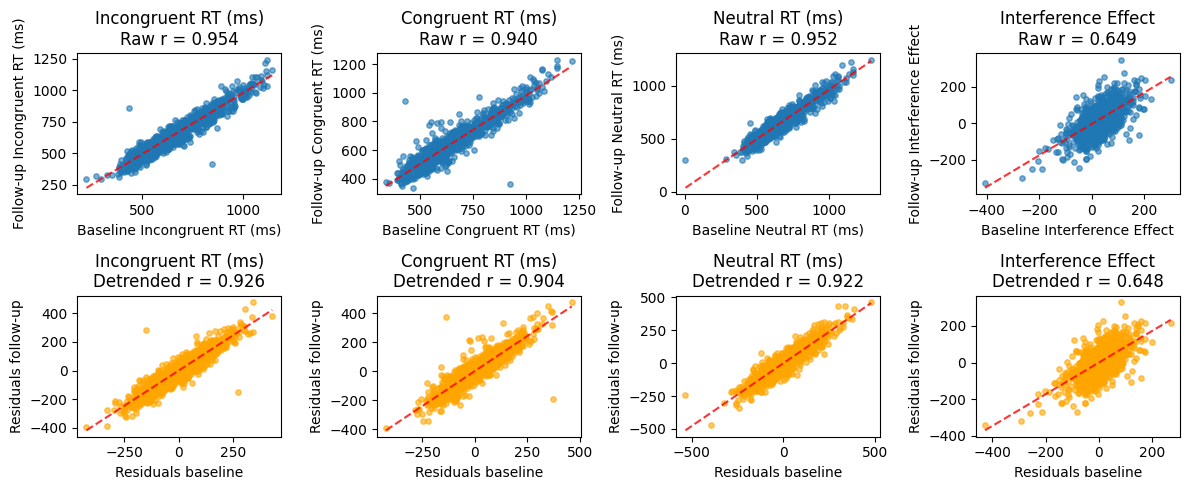


Stroop Summary of Test–Retest Reliabilities
Measure                   N     Raw r    Detrended r 
------------------------------------------------------------
Incongruent RT (ms)       995   0.954    0.926       
Congruent RT (ms)         995   0.940    0.904       
Neutral RT (ms)           995   0.952    0.922       
Interference Effect       995   0.649    0.648       

Results saved to 'stroop_detrended_reliability_results.xlsx'

Reliability interpretation guidelines:
r > 0.90: Excellent
0.80 < r ≤ 0.90: Good
0.70 < r ≤ 0.80: Acceptable
0.60 < r ≤ 0.70: Questionable
r ≤ 0.60: Poor


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_detrended_reliability(baseline, followup, age, measure_name):

    # Remove missing
    mask = ~(baseline.isna() | followup.isna() | age.isna())
    b = baseline[mask]
    f = followup[mask]
    a = age[mask]

    n = len(b)
    if n < 10:
        print(f"Warning: {measure_name} has too few valid cases (n={n})")
        return np.nan, np.nan, None, None

    # Raw test–retest
    raw_r, raw_p = stats.pearsonr(b, f)

    # Detrend by regressing out age
    lr1 = LinearRegression().fit(a.values.reshape(-1, 1), b)
    b_pred = lr1.predict(a.values.reshape(-1, 1))
    b_res = b - b_pred

    lr2 = LinearRegression().fit(a.values.reshape(-1, 1), f)
    f_pred = lr2.predict(a.values.reshape(-1, 1))
    f_res = f - f_pred

    detrended_r, detrended_p = stats.pearsonr(b_res, f_res)

    print(f"\n=== {measure_name} Test–Retest Reliability ===")
    print(f"Valid n: {n}")
    print(f"Baseline mean ± SD: {b.mean():.3f} ± {b.std():.3f}")
    print(f"Follow-up mean ± SD: {f.mean():.3f} ± {f.std():.3f}")
    print(f"Raw reliability: r = {raw_r:.3f}, p = {raw_p:.4f}")
    print(f"Detrended reliability: r = {detrended_r:.3f}, p = {detrended_p:.4f}")
    print(f"Age effect on baseline: β = {lr1.coef_[0]:.4f}")
    print(f"Age effect on follow-up: β = {lr2.coef_[0]:.4f}")

    return detrended_r, raw_r, b_res, f_res

def run_analysis(df, measures, age_col, prefix, fig_size):
    # Summary
    print(f"\n=== {prefix} Data Summary ===")
    print(f"Sample size: {len(df)}")
    print(f"Age range: {df[age_col].min():.1f} - {df[age_col].max():.1f} years")
    print(f"Mean age: {df[age_col].mean():.1f} ± {df[age_col].std():.1f} years")

    results = {}
    plt.figure(figsize=fig_size)
    for idx, (label, (col0, col1)) in enumerate(measures.items()):
        detrended_r, raw_r, b_res, f_res = calculate_detrended_reliability(
            df[col0], df[col1], df[age_col], label
        )
        results[label] = {
            'detrended_r': detrended_r,
            'raw_r': raw_r,
            'n': len(b_res) if b_res is not None else 0
        }
        if b_res is not None:
            # Raw scatter
            plt.subplot(2, len(measures), idx+1)
            plt.scatter(df[col0], df[col1], alpha=0.6, s=15)
            plt.xlabel(f'Baseline {label}')
            plt.ylabel(f'Follow-up {label}')
            plt.title(f'{label}\nRaw r = {raw_r:.3f}')
            z = np.polyfit(df[col0].dropna(), df[col1].dropna(), 1)
            p = np.poly1d(z)
            xvals = np.linspace(df[col0].min(), df[col0].max(), 100)
            plt.plot(xvals, p(xvals), 'r--', alpha=0.8)

            # Detrended scatter
            plt.subplot(2, len(measures), idx+1+len(measures))
            plt.scatter(b_res, f_res, alpha=0.6, s=15, color='orange')
            plt.xlabel('Residuals baseline')
            plt.ylabel('Residuals follow-up')
            plt.title(f'{label}\nDetrended r = {detrended_r:.3f}')
            z2 = np.polyfit(b_res, f_res, 1)
            p2 = np.poly1d(z2)
            x2 = np.linspace(b_res.min(), b_res.max(), 100)
            plt.plot(x2, p2(x2), 'r--', alpha=0.8)

    plt.tight_layout()
    plt.savefig(f'{prefix.lower()}_detrended_reliability_plots.png', dpi=800, bbox_inches='tight')
    plt.show()

    # Print summary table
    print("\n" + "="*60)
    print(f"{prefix} Summary of Test–Retest Reliabilities")
    print("="*60)
    print(f"{'Measure':<25} {'N':<5} {'Raw r':<8} {'Detrended r':<12}")
    print("-"*60)
    for measure, res in results.items():
        n = res['n']
        raw = res['raw_r']
        det = res['detrended_r']
        if not np.isnan(det):
            print(f"{measure:<25} {n:<5} {raw:<8.3f} {det:<12.3f}")
        else:
            print(f"{measure:<25} {n:<5} {'N/A':<8} {'N/A':<12}")

    # Save results to Excel
    results_df = pd.DataFrame(results).T
    results_df.to_excel(f'{prefix.lower()}_detrended_reliability_results.xlsx', index=True)
    print(f"\nResults saved to '{prefix.lower()}_detrended_reliability_results.xlsx'")
    return results_df

# ----------------------
# Go/No-Go analysis (first figure size 8x4.5)
# ----------------------
df_gonogo = pd.read_excel('Gonogo-followup-6mo的副本.xlsx')
gonogo_measures = {
    'Go Accuracy': ('Go_ACC', 'Go_ACC-followup'),
    'NoGo Accuracy': ('Nogo_ACC', 'Nogo_ACC-followup'),
    'Go Reaction Time (ms)': ('Go_RT_ms', 'Go_RT_ms-followup'),
    "d'": ("d_value", "d_value-followup")   # 新增 d' 值和随访
}
results_gonogo = run_analysis(
    df_gonogo,
    gonogo_measures,
    age_col='Age',
    prefix='Gonogo',
    fig_size=(12, 5)
)

# ----------------------
# Stroop analysis (second figure size 12x5)
# ----------------------
df_stroop = pd.read_excel('Stroop-followup-6mo的副本.xlsx')
stroop_measures = {
    'Incongruent RT (ms)': ('Incongruent', 'Incongruent-followup'),
    'Congruent RT (ms)':   ('Congruent',   'Congruent-followup'),
    'Neutral RT (ms)':     ('Neutral',     'Neutral-followup'),
    'Interference Effect': ('Interference','Interference-followup')
}
results_stroop = run_analysis(
    df_stroop,
    stroop_measures,
    age_col='Age',
    prefix='Stroop',
    fig_size=(12, 5)
)

# Combined reliability interpretation guidelines
print("\nReliability interpretation guidelines:")
print("r > 0.90: Excellent")
print("0.80 < r ≤ 0.90: Good")
print("0.70 < r ≤ 0.80: Acceptable")
print("0.60 < r ≤ 0.70: Questionable")
print("r ≤ 0.60: Poor")